---
title: Measuring Distribution Distances
author: Mark Fuge
date: 'October 20 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---


This notebook explores several ways of quantifying distances between one-dimensional probability distributions. We will contrast their mathematical definitions, visualize how they react to parameter changes, and compare the gradients that each metric produces. The goal is to build intuition for why the choice of divergence matters in optimization problems such as generative modeling or system identification. We will explore the following:

- Contrast forward KL, reverse KL, Jensen–Shannon divergence, Maximum Mean Discrepancy, Wasserstein distance, and Fisher–Rao metrics on simple families of distributions.
- Inspect how each distance responds to shifting the mean of a model Gaussian relative to a fixed target distribution.
- Visualize analytical or automatic-differentiation gradients to anticipate their effect on parameter updates.
- Experiment interactively with key hyperparameters (e.g., kernel bandwidth, mixture weights) to see how diagnostics change.

In [1]:
# Setup and shared imports
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Callable, Dict, Tuple

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

try:
    import seaborn as sns
    sns.set_context("talk")
except Exception:
    sns = None

try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    widgets = None
    display = None

# Ensure reproducibility for sampling-based diagnostics
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cpu")
DEFAULT_DTYPE = torch.float64

In [2]:
## Shared Distribution Utilities
# We will represent each distribution by two callables:
# - `pdf(x)` returning the probability density evaluated on a 1D tensor `x`.
# - `sample(n, base_noise)` producing differentiable samples (re-using base noise when we need gradients).

# To keep gradients tractable, we lean on reparameterizations for Gaussians and deterministic mixtures of Gaussians. For numerical integrals we discretize the domain on a dense grid.

# Dense grid for numerical integration and visualization
GRID_X = torch.linspace(-6.0, 6.0, 2048, dtype=DEFAULT_DTYPE, device=device)
DX = GRID_X[1] - GRID_X[0]
EPS = torch.tensor(1e-12, dtype=DEFAULT_DTYPE, device=device)


def gaussian_pdf_torch(x: torch.Tensor, mean: torch.Tensor | float, std: torch.Tensor | float) -> torch.Tensor:
    """Evaluate the Gaussian pdf on `x` using broadcasted parameters."""
    mean_t = torch.as_tensor(mean, dtype=DEFAULT_DTYPE, device=device)
    std_t = torch.as_tensor(std, dtype=DEFAULT_DTYPE, device=device)
    var = std_t ** 2
    norm_const = 1.0 / torch.sqrt(2.0 * math.pi * var)
    z = (x - mean_t) ** 2 / (2.0 * var)
    return norm_const * torch.exp(-z)


def uniform_pdf_torch(x: torch.Tensor, low: float, high: float) -> torch.Tensor:
    low_t = torch.as_tensor(low, dtype=DEFAULT_DTYPE, device=device)
    high_t = torch.as_tensor(high, dtype=DEFAULT_DTYPE, device=device)
    inside = (x >= low_t) & (x <= high_t)
    return inside.to(DEFAULT_DTYPE) / (high_t - low_t + EPS)


def gaussian_mixture_pdf_torch(
    x: torch.Tensor,
    means: torch.Tensor,
    stds: torch.Tensor,
    weights: torch.Tensor,
) -> torch.Tensor:
    comps = [w * gaussian_pdf_torch(x, m, s) for w, m, s in zip(weights, means, stds)]
    return torch.stack(comps, dim=0).sum(dim=0)


@dataclass(frozen=True)
class DistributionSpec:
    name: str
    pdf: Callable[[torch.Tensor], torch.Tensor]
    sampler: Callable[[int, torch.Tensor | None], torch.Tensor]
    metadata: Dict[str, float]


def make_gaussian(mean: float = 0.0, std: float = 1.0) -> DistributionSpec:
    mean_t = torch.tensor(mean, dtype=DEFAULT_DTYPE, device=device)
    std_t = torch.tensor(std, dtype=DEFAULT_DTYPE, device=device)

    def _pdf(x: torch.Tensor) -> torch.Tensor:
        return gaussian_pdf_torch(x, mean_t, std_t)

    def _sample(n: int, base_noise: torch.Tensor | None = None) -> torch.Tensor:
        eps = torch.randn(n, dtype=DEFAULT_DTYPE, device=device) if base_noise is None else base_noise
        return mean_t + std_t * eps

    meta = {"mean": float(mean), "std": float(std)}
    return DistributionSpec(name=f"Gaussian(μ={mean:.2f}, σ={std:.2f})", pdf=_pdf, sampler=_sample, metadata=meta)


def make_uniform(low: float = -2.0, high: float = 2.0) -> DistributionSpec:
    low_t = torch.tensor(low, dtype=DEFAULT_DTYPE, device=device)
    high_t = torch.tensor(high, dtype=DEFAULT_DTYPE, device=device)

    def _pdf(x: torch.Tensor) -> torch.Tensor:
        return uniform_pdf_torch(x, float(low_t), float(high_t))

    def _sample(n: int, base_noise: torch.Tensor | None = None) -> torch.Tensor:
        if base_noise is None:
            base_noise = torch.rand(n, dtype=DEFAULT_DTYPE, device=device)
        return low_t + (high_t - low_t) * base_noise

    meta = {"low": float(low), "high": float(high)}
    return DistributionSpec(name=f"Uniform[{low:.1f}, {high:.1f}]", pdf=_pdf, sampler=_sample, metadata=meta)


def make_gaussian_mixture(
    means: Tuple[float, float] = (-2.0, 2.0),
    stds: Tuple[float, float] = (0.6, 0.6),
    weights: Tuple[float, float] = (0.5, 0.5),
) -> DistributionSpec:
    means_t = torch.tensor(means, dtype=DEFAULT_DTYPE, device=device)
    stds_t = torch.tensor(stds, dtype=DEFAULT_DTYPE, device=device)
    weights_t = torch.tensor(weights, dtype=DEFAULT_DTYPE, device=device)
    weights_t = weights_t / weights_t.sum()

    def _pdf(x: torch.Tensor) -> torch.Tensor:
        return gaussian_mixture_pdf_torch(x, means_t, stds_t, weights_t)

    def _sample(n: int, base_noise: torch.Tensor | None = None) -> torch.Tensor:
        if base_noise is None:
            base_noise = torch.rand(n, dtype=DEFAULT_DTYPE, device=device)
        cumulative = torch.cumsum(weights_t, dim=0)
        choices = torch.bucketize(base_noise, cumulative)
        eps = torch.randn(n, dtype=DEFAULT_DTYPE, device=device)
        samples = torch.empty(n, dtype=DEFAULT_DTYPE, device=device)
        for idx, (m, s) in enumerate(zip(means_t, stds_t)):
            mask = choices == idx
            if mask.any():
                samples[mask] = m + s * eps[mask]
        return samples

    meta = {
        "means": tuple(float(m) for m in means),
        "stds": tuple(float(s) for s in stds),
        "weights": tuple(float(w) for w in weights),
    }
    desc = ", ".join([f"μ={m:.1f}" for m in means])
    return DistributionSpec(name=f"Gaussian Mixture ({desc})", pdf=_pdf, sampler=_sample, metadata=meta)

In [3]:
# Common plotting helpers
plt.rcParams.update({"figure.figsize": (10, 5), "axes.grid": True})


def plot_distribution_pair(
    grid: torch.Tensor,
    target_pdf: torch.Tensor,
    model_pdf: torch.Tensor,
    title: str,
    target_label: str = "Target",
    model_label: str = "Model",
) -> None:
    fig, ax = plt.subplots()
    ax.plot(grid.cpu().numpy(), target_pdf.cpu().numpy(), label=target_label, linewidth=2)
    ax.plot(grid.cpu().numpy(), model_pdf.cpu().numpy(), label=model_label, linestyle="--", linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()


def plot_metric_and_gradient(
    mu_values: np.ndarray,
    metric_values: np.ndarray,
    gradient_values: np.ndarray,
    metric_name: str,
    target_desc: str,
) -> None:
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(1, 2, figure=fig)
    ax_metric = fig.add_subplot(gs[0, 0])
    ax_grad = fig.add_subplot(gs[0, 1])

    ax_metric.plot(mu_values, metric_values, color="tab:blue", linewidth=2)
    ax_metric.set_title(f"{metric_name} vs. μ")
    ax_metric.set_xlabel("Model mean μ")
    ax_metric.set_ylabel(metric_name)

    ax_grad.plot(mu_values, gradient_values, color="tab:red", linewidth=2)
    ax_grad.axhline(0.0, color="black", linestyle=":", linewidth=1)
    ax_grad.set_title(f"Gradient d({metric_name})/dμ")
    ax_grad.set_xlabel("Model mean μ")
    ax_grad.set_ylabel("Gradient")

    fig.suptitle(f"{metric_name} against {target_desc}")
    fig.tight_layout()
    plt.show()


def evaluate_metric_curve(
    mu_values: np.ndarray,
    metric_fn: Callable[[torch.Tensor], torch.Tensor],
) -> Tuple[np.ndarray, np.ndarray]:
    metrics = []
    grads = []
    for mu in mu_values:
        mu_t = torch.tensor(mu, dtype=DEFAULT_DTYPE, device=device, requires_grad=True)
        metric = metric_fn(mu_t)
        grad = torch.autograd.grad(metric, mu_t)[0]
        metrics.append(metric.detach().cpu().item())
        grads.append(grad.detach().cpu().item())
    return np.array(metrics), np.array(grads)


def maybe_display(widget: widgets.Widget | None) -> None:
    if widget is None:
        print("ipywidgets not available in this environment. Install ipywidgets to enable interactivity.")
    else:
        display(widget)

In [4]:
# Define canonical target distributions used throughout the notebook
TARGETS: Dict[str, DistributionSpec] = {
    "gaussian": make_gaussian(mean=0.0, std=1.0),
    "wide_gaussian": make_gaussian(mean=0.0, std=1.8),
    "uniform": make_uniform(low=-3.0, high=3.0),
    "gaussian_mixture": make_gaussian_mixture(means=(-2.5, 2.5), stds=(0.6, 0.6), weights=(0.35, 0.65)),
}

#TARGETS

## A Toy Example: Comparing Two Gaussians
We will compare a *target* distribution $p(x)$ against a *model* distribution $q_\mu(x)$ whose mean $\mu$ we can adjust. Unless stated otherwise, the target will be the standard normal distribution. You can change that later to a uniform or a bimodal mixture to reveal different behaviours.

Our baseline parameterization keeps the model standard deviation fixed at $\sigma_q = 1$. Adjusting the mean already highlights how asymmetric divergences produce different gradient signals.

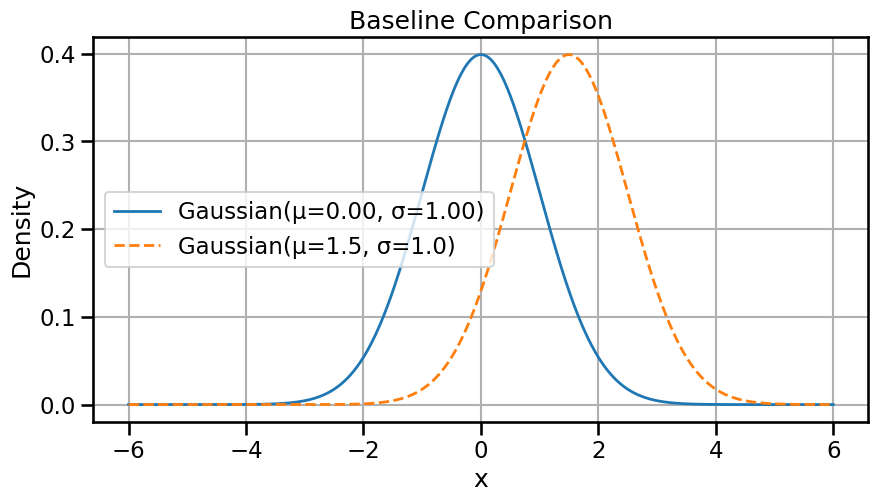

In [5]:
# Baseline visualization: standard normal target vs. shifted model Gaussian
TARGET = TARGETS["gaussian"]
MODEL_STD = torch.tensor(1.0, dtype=DEFAULT_DTYPE, device=device)
MU_BASE = torch.tensor(1.5, dtype=DEFAULT_DTYPE, device=device)

with torch.no_grad():
    target_pdf = TARGET.pdf(GRID_X)
    model_pdf = gaussian_pdf_torch(GRID_X, MU_BASE, MODEL_STD)

plot_distribution_pair(GRID_X, target_pdf, model_pdf, title="Baseline Comparison", target_label=TARGET.name, model_label=f"Gaussian(μ={MU_BASE.item():.1f}, σ=1.0)")

## Kullback–Leibler Divergence
Forward KL divergence compares how much mass the target distribution assigns relative to the model: 
$$
\mathrm{KL}(p\,\|\,q) = \int p(x) \log \frac{p(x)}{q(x)}\,dx.
$$
Because it integrates expectations under $p$, it heavily penalizes situations where $q(x)$ is small while $p(x)$ is large, even if the model allocates extra mass elsewhere.

### Analytical Gradient for Gaussian vs. Gaussian
For $p = \mathcal{N}(\mu_p, \sigma_p^2)$ and $q = \mathcal{N}(\mu, \sigma_q^2)$, forward KL admits a closed form:
$$
\mathrm{KL}(p\,\|\,q) = \log \frac{\sigma_q}{\sigma_p} + \frac{\sigma_p^2 + (\mu_p - \mu)^2}{2\sigma_q^2} - \frac{1}{2}.
$$
Differentiating w.r.t. the model mean gives
$$
\frac{\partial}{\partial \mu} \mathrm{KL}(p\,\|\,q) = \frac{\mu - \mu_p}{\sigma_q^2},
$$
which pushes $\mu$ directly toward $\mu_p$. We will evaluate the integral numerically to keep the pipeline consistent when we later switch to mixtures.

In [6]:
# Forward and reverse KL implementations using numerical integration
_target_pdf_cache: Dict[str, torch.Tensor] = {}


def get_target_pdf(spec: DistributionSpec) -> torch.Tensor:
    if spec.name not in _target_pdf_cache:
        with torch.no_grad():
            _target_pdf_cache[spec.name] = spec.pdf(GRID_X).detach()
    return _target_pdf_cache[spec.name]


def forward_kl(mu: torch.Tensor, target: DistributionSpec, model_std: float = 1.0) -> torch.Tensor:
    p_pdf = get_target_pdf(target)
    q_pdf = gaussian_pdf_torch(GRID_X, mu, model_std)
    integrand = p_pdf * torch.log((p_pdf + EPS) / (q_pdf + EPS))
    return torch.trapz(integrand, GRID_X)


def reverse_kl(mu: torch.Tensor, target: DistributionSpec, model_std: float = 1.0) -> torch.Tensor:
    p_pdf = get_target_pdf(target)
    q_pdf = gaussian_pdf_torch(GRID_X, mu, model_std)
    integrand = q_pdf * torch.log((q_pdf + EPS) / (p_pdf + EPS))
    return torch.trapz(integrand, GRID_X)

Now let's look at how the forward KL behaves as the model mean $\mu$ shifts away from the target mean $\mu_p = 0$. We will plot the KL divergence, and its gradient, as we shift the model mean from -15 to 15. What do you notice about the behavior of the KL Divergence and it's gradient?

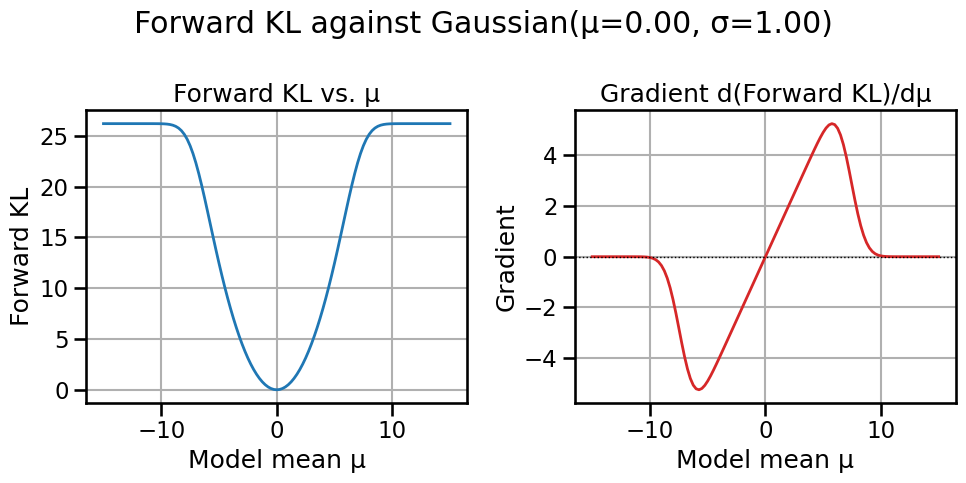

In [7]:
#| code-fold: false
# Forward KL distance curve for standard normal target
##### Change the following to see what happens #######
mu_values = np.linspace(-15.0, 15.0, 121)
model_std = 1.0
####################################

forward_metrics, forward_grads = evaluate_metric_curve(
    mu_values,
    lambda mu: forward_kl(mu, TARGETS["gaussian"], model_std=model_std),
)
plot_metric_and_gradient(mu_values, forward_metrics, forward_grads, metric_name="Forward KL", target_desc=TARGETS["gaussian"].name)

::: {.callout-tip appearance="default"}
### Experiment: Forward KL on Gaussian Targets
- What happens to both the KL Divergence and its gradient when the model mean is close to the target mean? What about when it is far away? Why is this?
- How would the curve change if we widened the model variance? Try modifying `model_std` in the code cell above and re-running it.
:::


In [8]:
# Interactive widget for forward KL
if widgets is None:
    maybe_display(None)
else:
    target_dropdown = widgets.Dropdown(
        options=[(spec.name, key) for key, spec in TARGETS.items()],
        value="gaussian",
        description="Target",
        style={"description_width": "initial"},
    )
    mu_slider = widgets.FloatSlider(value=0.0, min=-15.0, max=15.0, step=0.5, description="μ")
    std_slider = widgets.FloatSlider(value=1.0, min=0.4, max=2.5, step=0.1, description="σ_q")
    output = widgets.Output()

    def _update_forward_kl(*_):
        with output:
            output.clear_output(wait=True)
            target = TARGETS[target_dropdown.value]
            mu_val = torch.tensor(mu_slider.value, dtype=DEFAULT_DTYPE, device=device, requires_grad=True)
            std_val = float(std_slider.value)
            kl_value = forward_kl(mu_val, target, model_std=std_val)
            grad = torch.autograd.grad(kl_value, mu_val)[0].detach().cpu().item()
            target_pdf = get_target_pdf(target)
            model_pdf = gaussian_pdf_torch(GRID_X, mu_slider.value, std_val)

            mu_values = np.linspace(mu_slider.min, mu_slider.max, 181)
            metrics_curve, grads_curve = evaluate_metric_curve(
                mu_values,
                lambda mu: forward_kl(mu, target, model_std=std_val),
            )

            grid_np = GRID_X.cpu().numpy()
            target_np = target_pdf.cpu().numpy()
            model_np = model_pdf.cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(18, 4))

            axes[0].plot(grid_np, target_np, label=target.name, linewidth=2)
            axes[0].plot(grid_np, model_np, label=f"Model μ={mu_slider.value:.1f}, σ={std_val:.1f}", linestyle="--", linewidth=2)
            axes[0].set_title("Density comparison")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("Density")
            axes[0].legend()

            axes[1].plot(mu_values, metrics_curve, color="tab:blue", linewidth=2)
            axes[1].axvline(mu_slider.value, color="black", linestyle=":")
            axes[1].scatter([mu_slider.value], [kl_value.detach().cpu().item()], color="tab:blue")
            axes[1].set_title("Forward KL vs. μ")
            axes[1].set_xlabel("Model mean μ")
            axes[1].set_ylabel("Forward KL")

            axes[2].plot(mu_values, grads_curve, color="tab:red", linewidth=2)
            axes[2].axhline(0.0, color="black", linestyle=":")
            axes[2].axvline(mu_slider.value, color="black", linestyle=":")
            axes[2].scatter([mu_slider.value], [grad], color="tab:red")
            axes[2].set_title("Gradient d(KL)/dμ")
            axes[2].set_xlabel("Model mean μ")
            axes[2].set_ylabel("Gradient")

            fig.suptitle(
                f"Forward KL = {kl_value.detach().cpu().item():.3f} | Gradient = {grad:.3f}",
                fontsize=14,
            )
            fig.tight_layout()
            plt.show()

    for control in (target_dropdown, mu_slider, std_slider):
        control.observe(_update_forward_kl, names="value")

    _update_forward_kl()
    maybe_display(widgets.VBox([widgets.HTML("<h4>Interactive Forward KL Explorer</h4>"), target_dropdown, mu_slider, std_slider, output]))

### Forward vs. Reverse KL on a Bimodal Target
Reverse KL, $\mathrm{KL}(q\,\|\,p)$, prefers to avoid regions where the model would place mass but the target does not. On multimodal targets this often leads to *mode seeking*: the optimizer chooses one mode to cover while ignoring others.

#### Mathematical Overview
The reverse KL is defined as
$$
\mathrm{KL}(q\,\|\,p) = \int q(x) \log \frac{q(x)}{p(x)}\,dx,
$$
so the expectation is taken under the model distribution $q$. If $q(x)$ places mass where $p(x)$ is negligible, the logarithm term explodes and strongly penalizes those regions. Conversely, areas where $p$ has mass but $q$ does not contribute nothing, which is why the optimizer can collapse onto a single mode when matching multimodal targets.

Let us compare the two on a mixture of Gaussians.

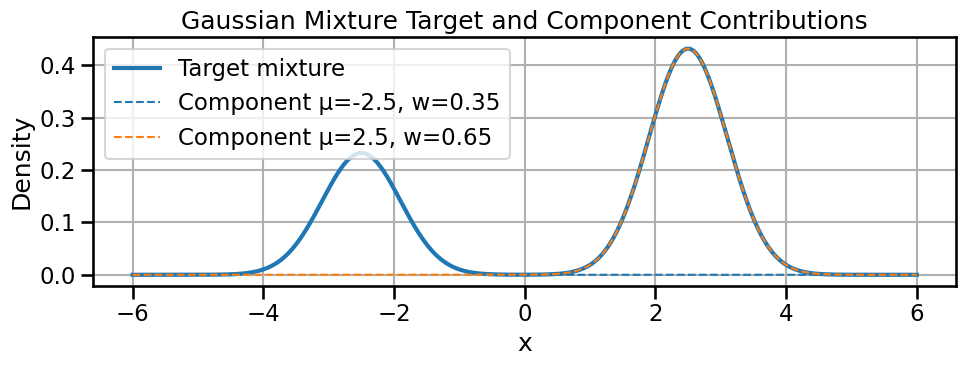

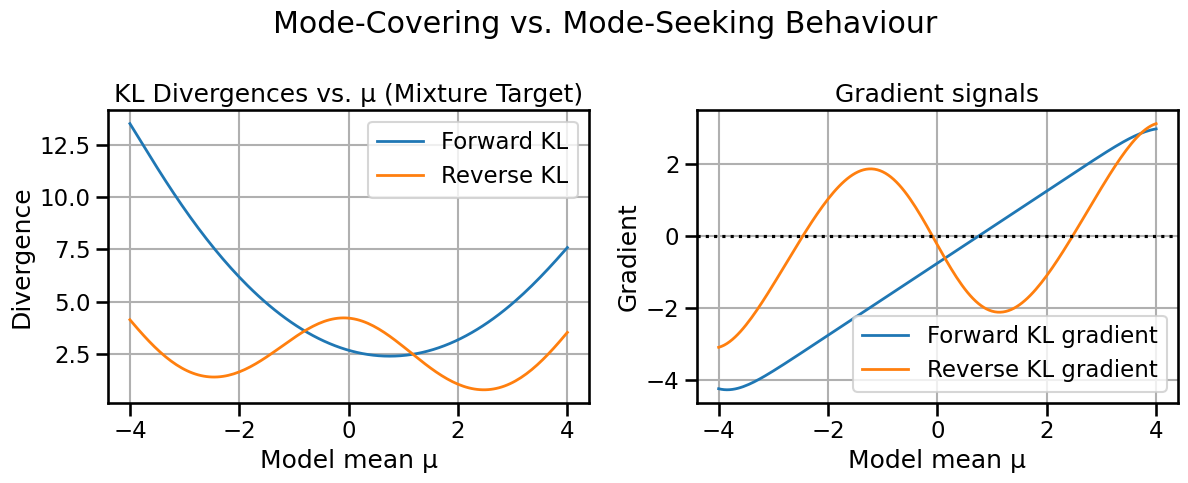

In [9]:
# Forward vs. reverse KL on a bimodal target
mixture_target = TARGETS["gaussian_mixture"]
component_means = mixture_target.metadata.get("means", (-2.5, 2.5))
component_stds = mixture_target.metadata.get("stds", (0.6, 0.6))
component_weights = mixture_target.metadata.get("weights", (0.5, 0.5))

with torch.no_grad():
    mixture_pdf = mixture_target.pdf(GRID_X).cpu().numpy()
    component_curves = []
    for mean, std, weight in zip(component_means, component_stds, component_weights):
        component_pdf = weight * gaussian_pdf_torch(GRID_X, mean, std)
        component_curves.append((mean, weight, component_pdf.cpu().numpy()))

grid_np = GRID_X.cpu().numpy()
fig_density, ax_density = plt.subplots(figsize=(10, 4))
ax_density.plot(grid_np, mixture_pdf, label="Target mixture", linewidth=3, color="tab:blue")
for mean, weight, comp_pdf in component_curves:
    ax_density.plot(
        grid_np,
        comp_pdf,
        linestyle="--",
        linewidth=1.5,
        label=f"Component μ={mean:.1f}, w={weight:.2f}",
    )
ax_density.set_title("Gaussian Mixture Target and Component Contributions")
ax_density.set_xlabel("x")
ax_density.set_ylabel("Density")
ax_density.legend()
fig_density.tight_layout()
plt.show()

mu_values = np.linspace(-4.0, 4.0, 161)
forward_metrics_mix, forward_grads_mix = evaluate_metric_curve(
    mu_values,
    lambda mu: forward_kl(mu, mixture_target, model_std=1.0),
)
reverse_metrics_mix, reverse_grads_mix = evaluate_metric_curve(
    mu_values,
    lambda mu: reverse_kl(mu, mixture_target, model_std=1.0),
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
axes[0].plot(mu_values, forward_metrics_mix, label="Forward KL", linewidth=2)
axes[0].plot(mu_values, reverse_metrics_mix, label="Reverse KL", linewidth=2)
axes[0].set_title("KL Divergences vs. μ (Mixture Target)")
axes[0].set_xlabel("Model mean μ")
axes[0].set_ylabel("Divergence")
axes[0].legend()

axes[1].plot(mu_values, forward_grads_mix, label="Forward KL gradient", linewidth=2)
axes[1].plot(mu_values, reverse_grads_mix, label="Reverse KL gradient", linewidth=2)
axes[1].axhline(0.0, color="black", linestyle=":")
axes[1].set_title("Gradient signals")
axes[1].set_xlabel("Model mean μ")
axes[1].set_ylabel("Gradient")
axes[1].legend()

fig.suptitle("Mode-Covering vs. Mode-Seeking Behaviour")
fig.tight_layout()
plt.show()


::: {.callout-tip appearance="default"}
### Reflection: Mode Covering vs. Mode Seeking
- Why does the forward KL gradient stay non-zero even between the two modes?  
- Identify the regions where the reverse KL gradient vanishes. How does that explain a model that only tracks one mode? 
:::


## Jensen–Shannon Divergence
The Jensen–Shannon (JS) divergence symmetrizes KL by averaging the two distributions: $m(x) = \tfrac{1}{2}(p(x)+q(x))$. It stays finite even when supports do not match and is bounded between 0 and $\log 2$.

### Mathematical Formulation
$$
\mathrm{JS}(p, q) = \tfrac{1}{2} \mathrm{KL}(p\,\|\,m) + \tfrac{1}{2} \mathrm{KL}(q\,\|\,m), \quad m = \tfrac{1}{2}(p + q).
$$
We will compute JS numerically on the same grid. Autograd gives us gradients through the logarithms as long as we keep everything in PyTorch tensors.

In [10]:
#| code-fold: false
def jensen_shannon(mu: torch.Tensor, target: DistributionSpec, model_std: float = 1.0) -> torch.Tensor:
    p_pdf = get_target_pdf(target)
    q_pdf = gaussian_pdf_torch(GRID_X, mu, model_std)
    m_pdf = 0.5 * (p_pdf + q_pdf)
    term_p = p_pdf * torch.log((p_pdf + EPS) / (m_pdf + EPS))
    term_q = q_pdf * torch.log((q_pdf + EPS) / (m_pdf + EPS))
    return 0.5 * torch.trapz(term_p, GRID_X) + 0.5 * torch.trapz(term_q, GRID_X)

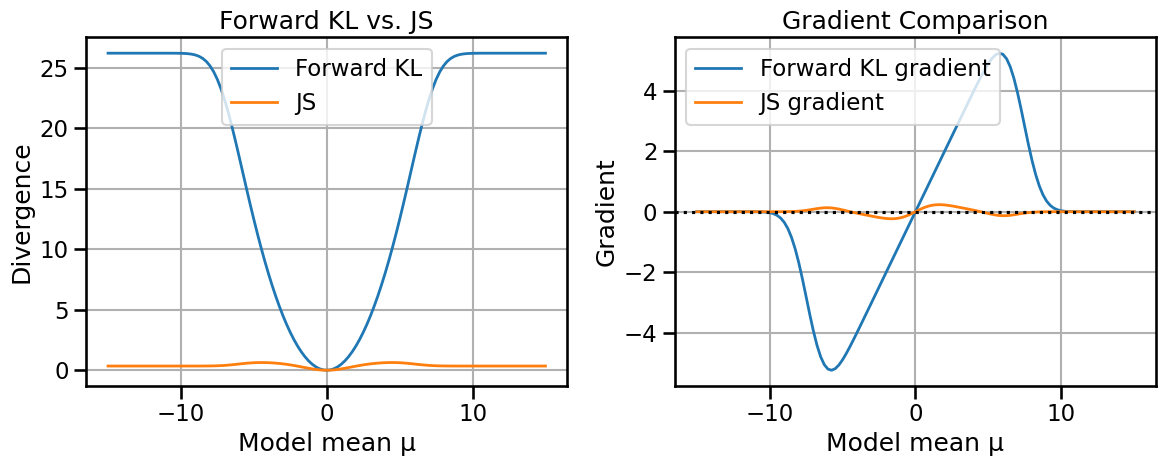

In [11]:
# JS divergence vs. μ for Gaussian target compared to forward KL
mu_values = np.linspace(-15.0, 15.0, 121)
js_metrics, js_grads = evaluate_metric_curve(
    mu_values,
    lambda mu: jensen_shannon(mu, TARGETS["gaussian"], model_std=1.0),
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
axes[0].plot(mu_values, forward_metrics, label="Forward KL", linewidth=2)
axes[0].plot(mu_values, js_metrics, label="JS", linewidth=2)
axes[0].set_title("Forward KL vs. JS")
axes[0].set_xlabel("Model mean μ")
axes[0].set_ylabel("Divergence")
axes[0].legend()

axes[1].plot(mu_values, forward_grads, label="Forward KL gradient", linewidth=2)
axes[1].plot(mu_values, js_grads, label="JS gradient", linewidth=2)
axes[1].axhline(0.0, color="black", linestyle=":")
axes[1].set_title("Gradient Comparison")
axes[1].set_xlabel("Model mean μ")
axes[1].set_ylabel("Gradient")
axes[1].legend()

fig.tight_layout()
plt.show()


::: {.callout-tip appearance="default"}
### Reflection: Bounded Divergence, Softer Gradients
- JS approaches $\log 2$ when the two distributions barely overlap. Where in the plot does that happen?  
- Compare the slope near $\mu=0$ for JS and forward KL. What do you notice?
- What happens when the distributions move far away from each other?
:::

In [12]:
# Interactive JS explorer
if widgets is None:
    maybe_display(None)
else:
    js_target_dropdown = widgets.Dropdown(
        options=[(spec.name, key) for key, spec in TARGETS.items()],
        value="gaussian",
        description="Target",
        style={"description_width": "initial"},
    )
    js_mu_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description="μ")
    js_std_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.5, step=0.1, description="σ_q")
    js_output = widgets.Output()

    def _update_js(*_):
        with js_output:
            js_output.clear_output(wait=True)
            target = TARGETS[js_target_dropdown.value]
            mu_val = torch.tensor(js_mu_slider.value, dtype=DEFAULT_DTYPE, device=device, requires_grad=True)
            std_val = float(js_std_slider.value)
            js_val = jensen_shannon(mu_val, target, model_std=std_val)
            grad = torch.autograd.grad(js_val, mu_val)[0].detach().cpu().item()
            target_pdf = get_target_pdf(target)
            model_pdf = gaussian_pdf_torch(GRID_X, js_mu_slider.value, std_val)

            mu_values = np.linspace(js_mu_slider.min, js_mu_slider.max, 181)
            metrics_curve, grads_curve = evaluate_metric_curve(
                mu_values,
                lambda mu: jensen_shannon(mu, target, model_std=std_val),
            )

            grid_np = GRID_X.cpu().numpy()
            target_np = target_pdf.cpu().numpy()
            model_np = model_pdf.cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(18, 4))

            axes[0].plot(grid_np, target_np, label=target.name, linewidth=2)
            axes[0].plot(grid_np, model_np, label=f"Model μ={js_mu_slider.value:.1f}, σ={std_val:.1f}", linestyle="--", linewidth=2)
            axes[0].set_title("Density comparison")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("Density")
            axes[0].legend()

            axes[1].plot(mu_values, metrics_curve, color="tab:blue", linewidth=2)
            axes[1].axvline(js_mu_slider.value, color="black", linestyle=":")
            axes[1].scatter([js_mu_slider.value], [js_val.detach().cpu().item()], color="tab:blue")
            axes[1].set_title("JS divergence vs. μ")
            axes[1].set_xlabel("Model mean μ")
            axes[1].set_ylabel("JS divergence")

            axes[2].plot(mu_values, grads_curve, color="tab:red", linewidth=2)
            axes[2].axhline(0.0, color="black", linestyle=":")
            axes[2].axvline(js_mu_slider.value, color="black", linestyle=":")
            axes[2].scatter([js_mu_slider.value], [grad], color="tab:red")
            axes[2].set_title("Gradient d(JS)/dμ")
            axes[2].set_xlabel("Model mean μ")
            axes[2].set_ylabel("Gradient")

            fig.suptitle(
                f"JS = {js_val.detach().cpu().item():.3f} | Gradient = {grad:.3f}",
                fontsize=14,
            )
            fig.tight_layout()
            plt.show()

    for control in (js_target_dropdown, js_mu_slider, js_std_slider):
        control.observe(_update_js, names="value")

    _update_js()
    maybe_display(widgets.VBox([widgets.HTML("<h4>Interactive JS Explorer</h4>"), js_target_dropdown, js_mu_slider, js_std_slider, js_output]))

## Maximum Mean Discrepancy (MMD)
MMD measures the distance between mean embeddings of distributions in a reproducing kernel Hilbert space (RKHS). With a kernel $k$,
$$
\mathrm{MMD}^2(p, q) = \mathbb{E}_{x, x' \sim p}[k(x, x')] - 2\, \mathbb{E}_{x \sim p, y \sim q}[k(x, y)] + \mathbb{E}_{y, y' \sim q}[k(y, y')].
$$
We will use the radial basis function (RBF) kernel
$$
k_\sigma(x, y) = \exp\!\left(-\tfrac{(x - y)^2}{2\sigma_k^2}\right),
$$
which assigns high similarity when two samples are closer than the bandwidth $\sigma_k$ and decays smoothly otherwise. A small $\sigma_k$ emphasises very local discrepancies—only nearby points contribute—so MMD becomes sensitive to fine-grained differences but can miss global shifts. A large $\sigma_k$ blurs the notion of neighbourhood, making the kernel respond to broader trends while down-weighting local wiggles. Balancing $\sigma_k$ therefore tunes whether we care more about microstructure or coarse alignment between $p$ and $q$. 

In [13]:
#| code-fold: false
# Shared noise tensors for deterministic MMD estimates
BASE_NOISE_NORMAL = torch.randn(4096, dtype=DEFAULT_DTYPE, device=device)
BASE_NOISE_UNIFORM = torch.linspace(0.0, 1.0, 4096, dtype=DEFAULT_DTYPE, device=device)


def sample_with_matching_noise(spec: DistributionSpec, sample_count: int) -> torch.Tensor:
    if "Uniform" in spec.name:
        base = BASE_NOISE_UNIFORM[:sample_count]
    else:
        base = BASE_NOISE_NORMAL[:sample_count]
    return spec.sampler(sample_count, base)


def rbf_kernel(x: torch.Tensor, y: torch.Tensor, bandwidth: float) -> torch.Tensor:
    bw = torch.as_tensor(bandwidth, dtype=DEFAULT_DTYPE, device=device)
    diff = x[:, None] - y[None, :]
    return torch.exp(-0.5 * diff.pow(2) / (bw ** 2 + EPS))


def maximum_mean_discrepancy(
    mu: torch.Tensor,
    target: DistributionSpec,
    model_std: float = 1.0,
    bandwidth: float = 1.0,
    sample_count: int = 512,
) -> torch.Tensor:
    samples_p = sample_with_matching_noise(target, sample_count)
    base_gauss = BASE_NOISE_NORMAL[:sample_count]
    samples_q = mu + model_std * base_gauss
    xx = rbf_kernel(samples_p, samples_p, bandwidth)
    yy = rbf_kernel(samples_q, samples_q, bandwidth)
    xy = rbf_kernel(samples_p, samples_q, bandwidth)
    xx = xx - torch.diag(torch.diag(xx))
    yy = yy - torch.diag(torch.diag(yy))
    n = sample_count
    mmd2 = xx.sum() / (n * (n - 1) + EPS) - 2.0 * xy.mean() + yy.sum() / (n * (n - 1) + EPS)
    return torch.sqrt(torch.clamp(mmd2, min=0.0))

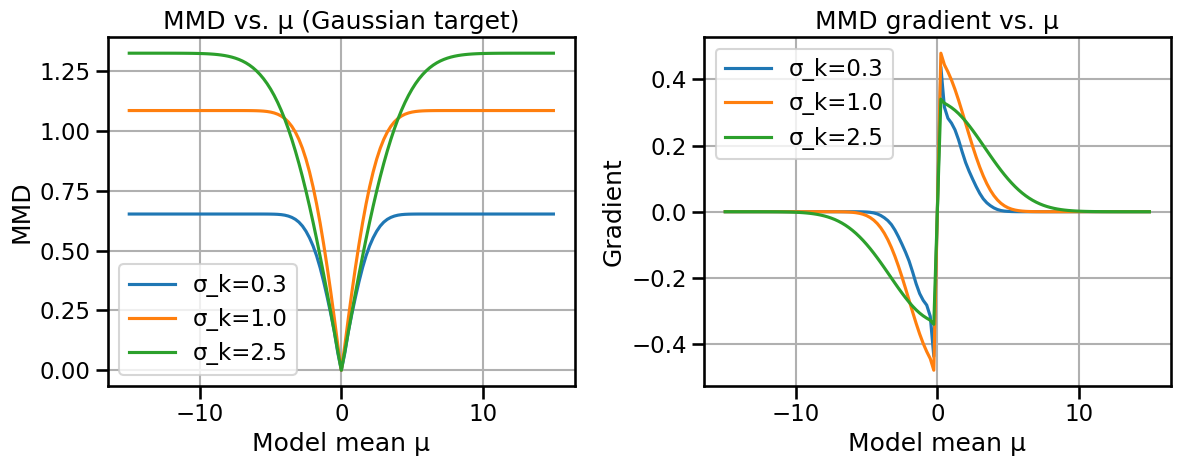

In [14]:
# MMD vs. μ for different kernel bandwidths
mu_values = np.linspace(-15.0, 15.0, 121)
bandwidths = [0.3, 1.0, 2.5]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
for bw in bandwidths:
    metrics, grads = evaluate_metric_curve(
        mu_values,
        lambda mu, bw=bw: maximum_mean_discrepancy(mu, TARGETS["gaussian"], model_std=1.0, bandwidth=bw),
    )
    axes[0].plot(mu_values, metrics, label=f"σ_k={bw}")
    axes[1].plot(mu_values, grads, label=f"σ_k={bw}")

axes[0].set_title("MMD vs. μ (Gaussian target)")
axes[0].set_xlabel("Model mean μ")
axes[0].set_ylabel("MMD")
axes[0].legend()

axes[1].set_title("MMD gradient vs. μ")
axes[1].set_xlabel("Model mean μ")
axes[1].set_ylabel("Gradient")
axes[1].legend()

fig.tight_layout()
plt.show()


::: {.callout-tip appearance="default"}
### Experiment: Effect of MMD Kernel Bandwidth
- Which bandwidth reacts most strongly to small shifts in $\mu$?  
- Observe how the gradient flattens for large $\sigma_k$. When might that be desirable?  
- How would you select $\sigma_k$ automatically in a learning system?
:::


In [15]:
# Interactive MMD explorer
if widgets is None:
    maybe_display(None)
else:
    mmd_target_dropdown = widgets.Dropdown(
        options=[(spec.name, key) for key, spec in TARGETS.items()],
        value="gaussian",
        description="Target",
        style={"description_width": "initial"},
    )
    mmd_mu_slider = widgets.FloatSlider(value=0.0, min=-15.0, max=15.0, step=0.5, description="μ")
    mmd_std_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.5, step=0.1, description="σ_q")
    mmd_bw_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-1, max=1, step=0.05, description="σ_k")
    mmd_output = widgets.Output()

    def _update_mmd(*_):
        with mmd_output:
            mmd_output.clear_output(wait=True)
            target = TARGETS[mmd_target_dropdown.value]
            mu_val = torch.tensor(mmd_mu_slider.value, dtype=DEFAULT_DTYPE, device=device, requires_grad=True)
            std_val = float(mmd_std_slider.value)
            bw_val = float(mmd_bw_slider.value)
            mmd_val = maximum_mean_discrepancy(mu_val, target, model_std=std_val, bandwidth=bw_val)
            grad = torch.autograd.grad(mmd_val, mu_val)[0].detach().cpu().item()

            mu_values = np.linspace(mmd_mu_slider.min, mmd_mu_slider.max, 181)
            metrics_curve, grads_curve = evaluate_metric_curve(
                mu_values,
                lambda mu: maximum_mean_discrepancy(mu, target, model_std=std_val, bandwidth=bw_val),
            )

            target_pdf = get_target_pdf(target)
            model_pdf = gaussian_pdf_torch(GRID_X, mmd_mu_slider.value, std_val)

            grid_np = GRID_X.cpu().numpy()
            target_np = target_pdf.cpu().numpy()
            model_np = model_pdf.cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(18, 4))

            axes[0].plot(grid_np, target_np, label=target.name, linewidth=2)
            axes[0].plot(grid_np, model_np, label=f"Model μ={mmd_mu_slider.value:.1f}, σ={std_val:.1f}", linestyle="--", linewidth=2)
            axes[0].set_title("Density comparison")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("Density")
            axes[0].legend()

            axes[1].plot(mu_values, metrics_curve, color="tab:blue", linewidth=2)
            axes[1].axvline(mmd_mu_slider.value, color="black", linestyle=":")
            axes[1].scatter([mmd_mu_slider.value], [mmd_val.detach().cpu().item()], color="tab:blue")
            axes[1].set_title("MMD vs. μ")
            axes[1].set_xlabel("Model mean μ")
            axes[1].set_ylabel("MMD")

            axes[2].plot(mu_values, grads_curve, color="tab:red", linewidth=2)
            axes[2].axhline(0.0, color="black", linestyle=":")
            axes[2].axvline(mmd_mu_slider.value, color="black", linestyle=":")
            axes[2].scatter([mmd_mu_slider.value], [grad], color="tab:red")
            axes[2].set_title("Gradient d(MMD)/dμ")
            axes[2].set_xlabel("Model mean μ")
            axes[2].set_ylabel("Gradient")

            fig.suptitle(
                f"MMD = {mmd_val.detach().cpu().item():.3f} | Gradient = {grad:.3f}",
                fontsize=14,
            )
            fig.tight_layout()
            plt.show()

    for control in (mmd_target_dropdown, mmd_mu_slider, mmd_std_slider, mmd_bw_slider):
        control.observe(_update_mmd, names="value")

    _update_mmd()
    maybe_display(
        widgets.VBox(
            [
                widgets.HTML("<h4>Interactive MMD Explorer</h4>"),
                mmd_target_dropdown,
                mmd_mu_slider,
                mmd_std_slider,
                mmd_bw_slider,
                mmd_output,
            ]
        )
    )

## Optimal Transport (Wasserstein-2 Distance)
Optimal Transport (OT) frames distribution comparison as the problem of moving probability mass from a source distribution $q$ to a target distribution $p$ at minimal cost. Given a ground cost $c(x, y)$ measuring how expensive it is to transport mass from $x$ to $y$, the quadratic OT problem seeks a coupling $\pi(x, y)$ with marginals $q$ and $p$ that minimises the total transport cost:
$$
W_2^2(p, q) = \inf_{\pi \in \Pi(p, q)} \int_{\mathbb{R}^d \times \mathbb{R}^d} \|x - y\|^2 \, d\pi(x, y),
$$
where $\Pi(p, q)$ denotes the set of joint distributions whose marginals are $p$ and $q$. This formulation differs from divergence-based distances above (KL, JS, MMD) because it explicitly models *where* probability mass must move, rather than comparing densities pointwise or via kernel similarities. As a result, OT remains informative even when supports do not overlap: the metric still reflects how far mass must travel to align the distributions.

In one dimension, the optimal coupling sorts both distributions and pairs quantiles. The squared Wasserstein-2 distance simplifies to
$$
W_2^2(p, q) = \int_0^1 \left|F_p^{-1}(u) - F_q^{-1}(u)\right|^2 \, du,
$$
with $F^{-1}$ denoting the quantile function. For Gaussians, this has a closed form $W_2^2 = (\mu_p - \mu)^2 + (\sigma_p - \sigma_q)^2$. We will compute it via quantile functions to keep the numerical pipeline consistent for non-Gaussian targets.

In [16]:
def gaussian_quantile(u: torch.Tensor, mean: float, std: float) -> torch.Tensor:
    mean_t = torch.as_tensor(mean, dtype=DEFAULT_DTYPE, device=device)
    std_t = torch.as_tensor(std, dtype=DEFAULT_DTYPE, device=device)
    return mean_t + std_t * math.sqrt(2.0) * torch.erfinv(2.0 * u - 1.0)


def wasserstein_2(
    mu: torch.Tensor,
    target: DistributionSpec,
    model_std: float = 1.0,
    sample_count: int = 1024,
) -> torch.Tensor:
    if target.name.startswith("Gaussian"):  # use closed form
        mu_p = target.metadata.get("mean", 0.0)
        sigma_p = target.metadata.get("std", 1.0)
        sigma_q = model_std
        diff_sq = (mu - mu_p) ** 2 + (sigma_q - sigma_p) ** 2
        return torch.sqrt(torch.clamp(diff_sq, min=0.0))

    # Empirical quantile-based estimate for non-Gaussian targets
    u = torch.linspace(0.0 + 0.5 / sample_count, 1.0 - 0.5 / sample_count, sample_count, dtype=DEFAULT_DTYPE, device=device)
    samples_p = torch.sort(sample_with_matching_noise(target, sample_count))[0]
    samples_q = torch.sort(mu + model_std * BASE_NOISE_NORMAL[:sample_count])[0]
    return torch.sqrt(torch.mean((samples_p - samples_q) ** 2))

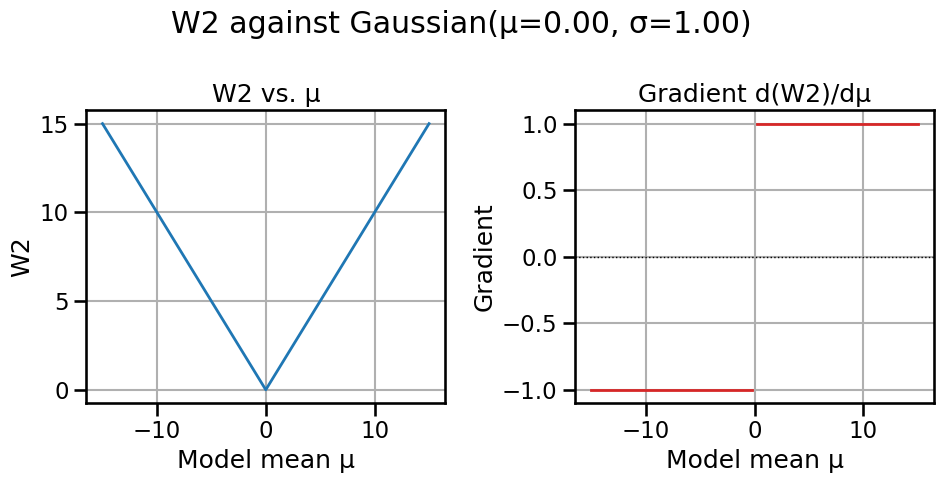

In [17]:
# Wasserstein-2 distance vs. μ for Gaussian target
mu_values = np.linspace(-15.0, 15.0, 121)
w2_metrics, w2_grads = evaluate_metric_curve(
    mu_values,
    lambda mu: wasserstein_2(mu, TARGETS["gaussian"], model_std=1.0),
)
plot_metric_and_gradient(mu_values, w2_metrics, w2_grads, metric_name="W2", target_desc=TARGETS["gaussian"].name)

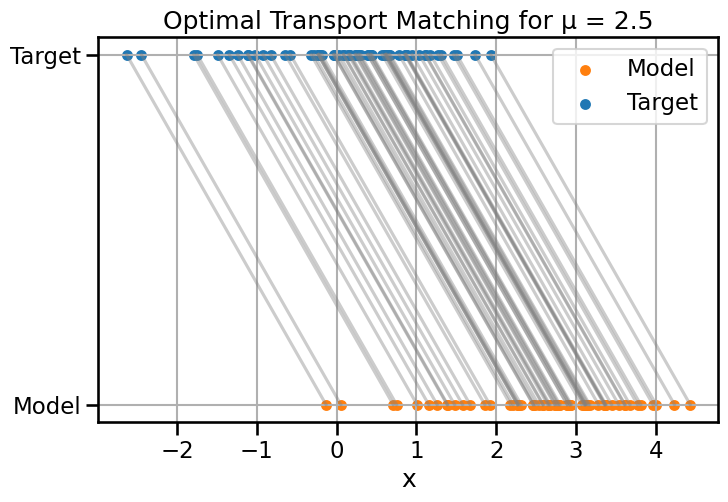

In [18]:
# Visualizing the optimal transport map in 1D
mu_demo = 2.5
sample_count = 64
u = torch.linspace(0.0 + 0.5 / sample_count, 1.0 - 0.5 / sample_count, sample_count, dtype=DEFAULT_DTYPE, device=device)
source_samples = torch.sort(mu_demo + BASE_NOISE_NORMAL[:sample_count])[0].cpu().numpy()
target_samples = torch.sort(sample_with_matching_noise(TARGETS["gaussian"], sample_count))[0].cpu().numpy()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(source_samples, np.zeros_like(source_samples), label="Model", color="tab:orange", s=40)
ax.scatter(target_samples, np.ones_like(target_samples), label="Target", color="tab:blue", s=40)
for xs, xt in zip(source_samples, target_samples):
    ax.plot([xs, xt], [0.0, 1.0], color="gray", alpha=0.4)
ax.set_title("Optimal Transport Matching for μ = 2.5")
ax.set_yticks([0, 1])
ax.set_yticklabels(["Model", "Target"])
ax.set_xlabel("x")
ax.legend()
plt.show()

::: {.callout-tip appearance="default"}
### Reflection: Transport as Matching
- How does the transport map change if you halve the model variance?  
- Compare the length of the transport lines with the Wasserstein distance you computed earlier.  
- What would happen if the target distribution had gaps (e.g., a mixture)? Sketch the expected matching pattern.
:::


In [19]:
# Interactive Wasserstein explorer
if widgets is None:
    maybe_display(None)
else:
    w2_target_dropdown = widgets.Dropdown(
        options=[(spec.name, key) for key, spec in TARGETS.items()],
        value="gaussian",
        description="Target",
        style={"description_width": "initial"},
    )
    w2_mu_slider = widgets.FloatSlider(value=0.0, min=-15.0, max=15.0, step=0.1, description="μ")
    w2_std_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.5, step=0.1, description="σ_q")
    w2_output = widgets.Output()

    def _update_w2(*_):
        with w2_output:
            w2_output.clear_output(wait=True)
            target = TARGETS[w2_target_dropdown.value]
            mu_val = torch.tensor(w2_mu_slider.value, dtype=DEFAULT_DTYPE, device=device, requires_grad=True)
            std_val = float(w2_std_slider.value)
            w2_val = wasserstein_2(mu_val, target, model_std=std_val)
            grad = torch.autograd.grad(w2_val, mu_val)[0].detach().cpu().item()

            mu_values = np.linspace(w2_mu_slider.min, w2_mu_slider.max, 181)
            metrics_curve, grads_curve = evaluate_metric_curve(
                mu_values,
                lambda mu: wasserstein_2(mu, target, model_std=std_val),
            )

            target_pdf = get_target_pdf(target)
            model_pdf = gaussian_pdf_torch(GRID_X, w2_mu_slider.value, std_val)

            grid_np = GRID_X.cpu().numpy()
            target_np = target_pdf.cpu().numpy()
            model_np = model_pdf.cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(18, 4))

            axes[0].plot(grid_np, target_np, label=target.name, linewidth=2)
            axes[0].plot(grid_np, model_np, label=f"Model μ={w2_mu_slider.value:.1f}, σ={std_val:.1f}", linestyle="--", linewidth=2)
            axes[0].set_title("Density comparison")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("Density")
            axes[0].legend()

            axes[1].plot(mu_values, metrics_curve, color="tab:blue", linewidth=2)
            axes[1].axvline(w2_mu_slider.value, color="black", linestyle=":")
            axes[1].scatter([w2_mu_slider.value], [w2_val.detach().cpu().item()], color="tab:blue")
            axes[1].set_title("Wasserstein-2 vs. μ")
            axes[1].set_xlabel("Model mean μ")
            axes[1].set_ylabel("W2 distance")

            axes[2].plot(mu_values, grads_curve, color="tab:red", linewidth=2)
            axes[2].axhline(0.0, color="black", linestyle=":")
            axes[2].axvline(w2_mu_slider.value, color="black", linestyle=":")
            axes[2].scatter([w2_mu_slider.value], [grad], color="tab:red")
            axes[2].set_title("Gradient d(W2)/dμ")
            axes[2].set_xlabel("Model mean μ")
            axes[2].set_ylabel("Gradient")

            fig.suptitle(
                f"W2 = {w2_val.detach().cpu().item():.3f} | Gradient = {grad:.3f}",
                fontsize=14,
            )
            fig.tight_layout()
            plt.show()

            if not target.name.startswith("Gaussian"):
                transport_samples = 80
                src = torch.sort(mu_val.detach() + std_val * BASE_NOISE_NORMAL[:transport_samples])[0].cpu().numpy()
                tgt = torch.sort(sample_with_matching_noise(target, transport_samples))[0].cpu().numpy()
                fig_map, ax_map = plt.subplots(figsize=(8, 4))
                ax_map.scatter(src, np.zeros_like(src), label="Model", color="tab:orange", s=25)
                ax_map.scatter(tgt, np.ones_like(tgt), label="Target", color="tab:blue", s=25)
                for xs, xt in zip(src, tgt):
                    ax_map.plot([xs, xt], [0.0, 1.0], color="gray", alpha=0.3)
                ax_map.set_yticks([0, 1])
                ax_map.set_yticklabels(["Model", "Target"])
                ax_map.set_title("Transport plan snapshot")
                ax_map.legend(loc="upper left")
                fig_map.tight_layout()
                plt.show()

    for control in (w2_target_dropdown, w2_mu_slider, w2_std_slider):
        control.observe(_update_w2, names="value")

    _update_w2()
    maybe_display(widgets.VBox([widgets.HTML("<h4>Interactive Wasserstein Explorer</h4>"), w2_target_dropdown, w2_mu_slider, w2_std_slider, w2_output]))

## Information Geometry vs. Optimal Transport
Information Geometry treats families of probability distributions as curved manifolds equipped with the Fisher information metric. Intuitively, it asks: *how sensitive are likelihoods to infinitesimal parameter changes?* The geometry that emerges is tailored to statistical inference—geodesics correspond to paths that keep models maximally informative, and inner products reflect the Cramér–Rao notion of efficiency. This is why information-geometric tools appear in natural gradient descent, variational inference, and sensor placement problems where we care about how much information parameters carry about data.

Because the Fisher–Rao metric lives on the parameter manifold, it is invariant to reparameterisations and emphasises directions where the distribution changes *statistically* rather than *spatially*. In contrast, Optimal Transport metrics such as $W_2$ operate directly on the sample space and quantify how far probability mass must move. OT is therefore ideal when spatial structure matters—think of matching shapes, aligning time-series histograms, or enforcing smooth transport maps in PDE-constrained problems.

When would you pick one over the other?
- Use Information Geometry when optimizing probabilistic models with latent variables or exponential-family structure, where natural gradients provide preconditioning aligned with likelihood curvature.
- Use OT when discrepancies in physical space are key, such as calibrating simulators to sensor data, training generative models that must respect spatial coherence, or comparing distributions with disjoint supports. It is also useful when the target distributions do not have an analytical form but samples are available.

Let us compare the two on Gaussian families and visualize the geodesic paths they induce.

In [20]:
try:
    from geomstats.geometry.normal_distribution import NormalDistributions
    from geomstats.learning.frechet_mean import FrechetMean
    GEOMSTATS_AVAILABLE = True
except Exception:
    GEOMSTATS_AVAILABLE = False


def fisher_rao_distance(mu1: float, sigma1: float, mu2: float, sigma2: float) -> float:
    term = (sigma1 ** 2 + sigma2 ** 2 + (mu1 - mu2) ** 2) / (2.0 * sigma1 * sigma2)
    term = max(term, 1.0)
    return math.sqrt(2.0) * math.acosh(term)


def ot_geodesic(mu1: float, sigma1: float, mu2: float, sigma2: float, num_points: int = 50) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    ts = np.linspace(0.0, 1.0, num_points)
    mus = (1 - ts) * mu1 + ts * mu2
    sigmas = (1 - ts) * sigma1 + ts * sigma2
    return ts, mus, sigmas


def fisher_rao_geodesic(mu1: float, sigma1: float, mu2: float, sigma2: float, num_points: int = 50) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    ts = np.linspace(0.0, 1.0, num_points)
    if GEOMSTATS_AVAILABLE:
        manifold = NormalDistributions()
        path = manifold.geodesic(initial_point=np.array([mu1, sigma1 ** 2]), end_point=np.array([mu2, sigma2 ** 2]))
        geodesic_points = np.array([path(t) for t in ts])
        mus = geodesic_points[:, 0]
        sigmas = np.sqrt(np.abs(geodesic_points[:, 1]))
        return ts, mus, sigmas
    # Fallback: interpolate in natural parameters (μ/σ, log σ)
    theta1 = np.array([mu1 / sigma1, math.log(sigma1)])
    theta2 = np.array([mu2 / sigma2, math.log(sigma2)])
    thetas = np.outer(1 - ts, theta1) + np.outer(ts, theta2)
    sigmas = np.exp(thetas[:, 1])
    mus = thetas[:, 0] * sigmas
    return ts, mus, sigmas

In [21]:
# Compare Wasserstein-2 and Fisher-Rao distances/geodesics
if widgets is None:
    mu1, sigma1 = 0.0, 1.0
    mu2, sigma2 = 2.5, 0.5

    w2_val = wasserstein_2(
        torch.tensor(mu2, dtype=DEFAULT_DTYPE, device=device),
        make_gaussian(mean=mu1, std=sigma1),
        model_std=sigma2,
    ).item()
    fr_val = fisher_rao_distance(mu1, sigma1, mu2, sigma2)
    print(f"W2(p, q) = {w2_val:.3f}\nFisher–Rao(p, q) = {fr_val:.3f}")

    ts_ot, mus_ot, sigmas_ot = ot_geodesic(mu1, sigma1, mu2, sigma2, num_points=200)
    ts_fr, mus_fr, sigmas_fr = fisher_rao_geodesic(mu1, sigma1, mu2, sigma2, num_points=200)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(ts_ot, mus_ot, label="OT geodesic", linewidth=2)
    axes[0].plot(ts_fr, mus_fr, label="Fisher–Rao geodesic", linewidth=2)
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("Mean μ(t)")
    axes[0].set_title("Mean evolution")
    axes[0].legend()

    axes[1].plot(ts_ot, sigmas_ot, label="OT geodesic", linewidth=2)
    axes[1].plot(ts_fr, sigmas_fr, label="Fisher–Rao geodesic", linewidth=2)
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("Std σ(t)")
    axes[1].set_title("Scale evolution")
    axes[1].legend()

    fig.tight_layout()
    plt.show()

    sample_ts = np.linspace(0.0, 1.0, 6)
    colors = plt.cm.viridis(sample_ts)
    grid_np = GRID_X.cpu().numpy()

    fig_interp, interp_axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for t_val, color in zip(sample_ts, colors):
        mu_t_ot = np.interp(t_val, ts_ot, mus_ot)
        sigma_t_ot = np.interp(t_val, ts_ot, sigmas_ot)
        pdf_ot = gaussian_pdf_torch(GRID_X, mu_t_ot, sigma_t_ot).cpu().numpy()
        interp_axes[0].plot(grid_np, pdf_ot, color=color, linewidth=2, label=f"t={t_val:.2f}")

    interp_axes[0].set_title("OT interpolation (W2 geodesic)")
    interp_axes[0].set_xlabel("x")
    interp_axes[0].set_ylabel("Density")
    interp_axes[0].legend(loc="upper right", ncol=2)

    for t_val, color in zip(sample_ts, colors):
        mu_t_fr = np.interp(t_val, ts_fr, mus_fr)
        sigma_t_fr = np.interp(t_val, ts_fr, sigmas_fr)
        pdf_fr = gaussian_pdf_torch(GRID_X, mu_t_fr, sigma_t_fr).cpu().numpy()
        interp_axes[1].plot(grid_np, pdf_fr, color=color, linewidth=2, label=f"t={t_val:.2f}")

    interp_axes[1].set_title("Information-geometry interpolation (Fisher–Rao)")
    interp_axes[1].set_xlabel("x")
    interp_axes[1].legend(loc="upper right", ncol=2)

    fig_interp.tight_layout()
    plt.show()
else:
    ig_mu1_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.1, description="μ₁")
    ig_sigma1_slider = widgets.FloatSlider(value=1.0, min=0.2, max=3.0, step=0.05, description="σ₁")
    ig_mu2_slider = widgets.FloatSlider(value=2.5, min=-4.0, max=4.0, step=0.1, description="μ₂")
    ig_sigma2_slider = widgets.FloatSlider(value=0.5, min=0.2, max=3.0, step=0.05, description="σ₂")
    ig_output = widgets.Output()

    def _update_geodesic(*_):
        with ig_output:
            ig_output.clear_output(wait=True)
            mu1 = float(ig_mu1_slider.value)
            sigma1 = float(ig_sigma1_slider.value)
            mu2 = float(ig_mu2_slider.value)
            sigma2 = float(ig_sigma2_slider.value)

            w2_val = wasserstein_2(
                torch.tensor(mu2, dtype=DEFAULT_DTYPE, device=device),
                make_gaussian(mean=mu1, std=sigma1),
                model_std=sigma2,
            ).item()
            fr_val = fisher_rao_distance(mu1, sigma1, mu2, sigma2)
            print(f"W2(p, q) = {w2_val:.3f}\nFisher–Rao(p, q) = {fr_val:.3f}")

            ts_ot, mus_ot, sigmas_ot = ot_geodesic(mu1, sigma1, mu2, sigma2, num_points=200)
            ts_fr, mus_fr, sigmas_fr = fisher_rao_geodesic(mu1, sigma1, mu2, sigma2, num_points=200)

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].plot(ts_ot, mus_ot, label="OT geodesic", linewidth=2)
            axes[0].plot(ts_fr, mus_fr, label="Fisher–Rao geodesic", linewidth=2)
            axes[0].set_xlabel("t")
            axes[0].set_ylabel("Mean μ(t)")
            axes[0].set_title("Mean evolution")
            axes[0].legend()

            axes[1].plot(ts_ot, sigmas_ot, label="OT geodesic", linewidth=2)
            axes[1].plot(ts_fr, sigmas_fr, label="Fisher–Rao geodesic", linewidth=2)
            axes[1].set_xlabel("t")
            axes[1].set_ylabel("Std σ(t)")
            axes[1].set_title("Scale evolution")
            axes[1].legend()

            fig.tight_layout()
            plt.show()

            sample_ts = np.linspace(0.0, 1.0, 6)
            colors = plt.cm.viridis(sample_ts)
            grid_np = GRID_X.cpu().numpy()

            fig_interp, interp_axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
            for t_val, color in zip(sample_ts, colors):
                mu_t_ot = np.interp(t_val, ts_ot, mus_ot)
                sigma_t_ot = np.interp(t_val, ts_ot, sigmas_ot)
                pdf_ot = gaussian_pdf_torch(GRID_X, mu_t_ot, sigma_t_ot).cpu().numpy()
                interp_axes[0].plot(grid_np, pdf_ot, color=color, linewidth=2, label=f"t={t_val:.2f}")

            interp_axes[0].set_title("OT interpolation (W2 geodesic)")
            interp_axes[0].set_xlabel("x")
            interp_axes[0].set_ylabel("Density")
            interp_axes[0].legend(loc="upper right", ncol=2)

            for t_val, color in zip(sample_ts, colors):
                mu_t_fr = np.interp(t_val, ts_fr, mus_fr)
                sigma_t_fr = np.interp(t_val, ts_fr, sigmas_fr)
                pdf_fr = gaussian_pdf_torch(GRID_X, mu_t_fr, sigma_t_fr).cpu().numpy()
                interp_axes[1].plot(grid_np, pdf_fr, color=color, linewidth=2, label=f"t={t_val:.2f}")

            interp_axes[1].set_title("Information-geometry interpolation (Fisher–Rao)")
            interp_axes[1].set_xlabel("x")
            interp_axes[1].legend(loc="upper right", ncol=2)

            fig_interp.tight_layout()
            plt.show()

    for control in (ig_mu1_slider, ig_sigma1_slider, ig_mu2_slider, ig_sigma2_slider):
        control.observe(_update_geodesic, names="value")

    _update_geodesic()
    controls = widgets.HBox([widgets.VBox([ig_mu1_slider, ig_sigma1_slider]), widgets.VBox([ig_mu2_slider, ig_sigma2_slider])])
    maybe_display(widgets.VBox([widgets.HTML("<h4>IG vs. OT Geodesic Explorer</h4>"), controls, ig_output]))


::: {.callout-tip appearance="default"}
### Experiment: Comparison of OT versus Fisher–Rao
- OT interpolates linearly in the mean; Fisher–Rao bends the path. How might that influence optimization trajectories?  
- Which metric is more sensitive to changes in variance vs. mean in this example?  
- If you needed to regularize a generative model toward a reference Gaussian, which geometry would you prefer and why?
:::


## Wrap-Up
We inspected five prominent distribution distances, paying attention to the gradients they induce for a simple Gaussian parameter. Key takeaways:
- KL divergences emphasize support mismatch and can be asymmetric in how they penalize missing mass.
- JS divergence softens gradients and stays bounded, making it attractive for adversarial training.
- MMD exposes the role of kernel bandwidth in shaping sensitivity to local vs. global structure.
- Wasserstein distance reasons about mass transport and yields interpretable gradient flows.
- Fisher–Rao geometry offers a complementary, information-theoretic notion of proximity with different geodesics.
